# ISEL - CPS 
## Semestre 2021/22
# <br>
###  <center> Trabalho Prático 2</center>
# </br>

Trabalho realizado por:
- António Ferreia, número <b> 47500 </b>
- Tomás Gomes, número <b> 48614 </b>




Import's

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from IPython.display import Audio, display
import IPython.display as ipd

A figura representa o esquema típico do processo de envio e recepção de informação usando modulações
digitais.

![fig_trab](esquemaCPS.png)

O 2º trabalho foca os blocos Codificação/descodificação do sinal e os blocos Deteção e Correção de erros. O canal é modelado pelo modelo Binary Symmetric Channel ([BSC](https://en.wikipedia.org/wiki/Binary_symmetric_channel)) 

# Codificação
Construa uma função Python que dado um Numpy array (com dimensão $N$) com valores inteiros, retorne um Numpy array (com dimensão $N.R\times 1$) com os mesmos valores convertidos para binário.
Esta função ainda deve receber como parâmetros de entrada o número de bits ($R$) a usar na conversão de cada inteiro.


In [2]:
def Codific(arr_signal_quantized,R):
    L = 2**R
    arr_signal_quantized = [int(i) for i in arr_signal_quantized]
    arr_binary = np.array([np.binary_repr(min(max(y,0),L-1), width=R) for y in arr_signal_quantized]).flatten()
    arr_binary = (''.join(arr_binary))
    arr_binary = [int(i) for i in arr_binary]
    return arr_binary

In [3]:
array = np.array([1,2,3])
Codific(array,2)

[0, 1, 1, 0, 1, 1]

Construa uma função que dado um Numpy array com valores os bits, faça a conversão para inteiros (considerando R bits).

In [4]:
def Descodific(arr_binary,R):
    arr_signal = [int("".join(str(i) for i in arr_binary[x:x+R]),2) for x in np.arange(0,len(arr_binary),R)]
    return arr_signal

In [5]:
print(Descodific(Codific([1,2,3],7),7))

[1, 2, 3]


In [6]:
def Quantific(R,Vmax,Qtype):
    L = 2.**R 
    delta = (2.*Vmax)/L
    delta_2 = delta/2
    v_max_posi = (L-1)*delta_2
    
    Vq = np.arange(-v_max_posi, v_max_posi+delta, delta)
    Iq = np.arange(-Vmax, Vmax+delta, delta)

    if(Qtype == 'midtread'): # midtread
        Iq[1:-1] = Iq[1:-1]+delta_2
        Vq = Vq + delta_2

    return Vq, Iq

In [7]:
def Quantificador(Rx, Vq, Iq):
    iq = np.digitize(Rx,Iq)
    iq = np.array([len(Vq)-1 if Rx >= len(Vq) else Rx for Rx in iq])
    xq = Vq[iq-1]
    return xq

In [8]:
def Measure_SNRp(signal, signalQ):
    error = np.subtract(signal, signalQ)
    SNRp = 10 * np.log10(sum(signal**2) / sum(error**2))
    return SNRp

In [9]:
def Measure_SNRt(signal, VqMax, R):
    P = sum(signal**2.)/len(signal) 
    SNRt = 6.02 * R + 10 * (np.log10((3 * P) / (VqMax)))
    return SNRt

#####  1) Teste usando as funções com o audio

Com base nas funções já implementadas, faça a codificação e descodificação PCM uniforme do sinal de áudio previamente gravado.
Verifique qual a SNR obtida e ouça o sinal descodificado. 
Use para o efeito R=3, 5 e 8.

In [10]:
file = 'audio.wav'
Fs, x = wav.read(file)
Ts = 1/Fs
R = np.array([3,5,8])
#R = np.array([3,5,8,12])

SNRPs = []
SNRTs = []
quantificacoes = []
codificacoes = []
descodificacoes = []
for r in R:
    Vq, Iq = Quantific(r,max(x),'midtread')
    x0 = Quantificador(x,Vq,Iq)
    quantificacoes.append(x0)
    codificacoes.append(Codific(x0,r))
    descodificacoes.append(Descodific(codificacoes[-1],r))
    SNRPs.append(Measure_SNRp(x,x0))
    SNRTs.append(Measure_SNRt(x0,max(x),r))

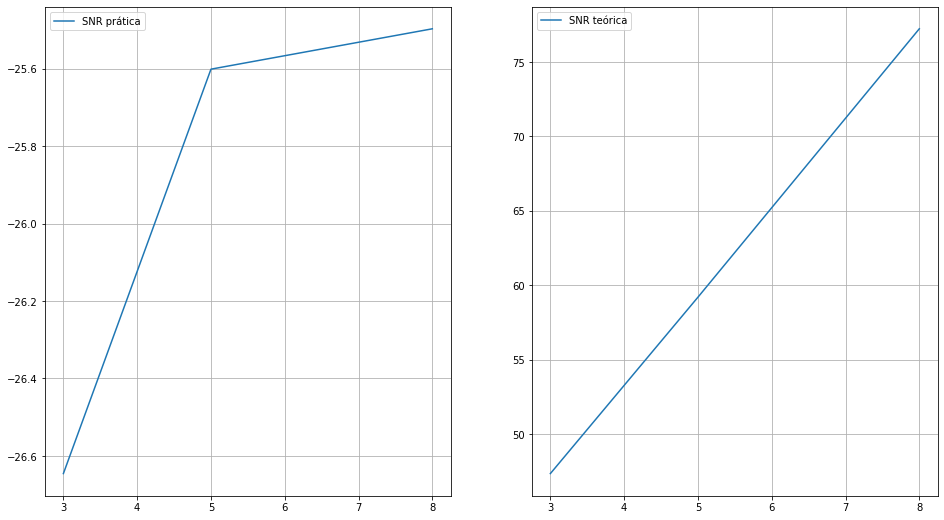

In [11]:
plt.subplots(1,2, figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(R,SNRPs, label="SNR prática")
plt.grid("on")
plt.legend()
plt.subplot(1,2,2)
plt.plot(R,SNRTs, label="SNR teórica")
plt.grid("on")
plt.legend()

In [12]:
print('Audio: original')
display(Audio(data=x,rate=48000))
print('Audio: usando 3 bits,')
display(Audio(data=descodificacoes[0],rate=48000))
print('Audio: usando 5 bits,')
display(Audio(data=descodificacoes[1],rate=48000))
print('Audio: usando 8 bits,')
display(Audio(data=descodificacoes[2],rate=48000))
#Teste apenas de verificação de qualidade de audio
#print('Audio: usando 12 bits')
#display(Audio(data=descodificacoes[3],rate=48000))

Audio: original


Audio: usando 3 bits,


Audio: usando 5 bits,


Audio: usando 8 bits,


#### 2) Teste usando a imagem "Lena Gray"

Faça o mesmo teste mas agora com a imagem fornecida.
comente os resultados obtidos.

In [13]:
from PIL import Image
from matplotlib import cm

In [14]:
im = Image.open("lena_gray.bmp")
img = np.array(im)
sinal_img = np.array(img.reshape(-1))
Vmax = int( max(sinal_img) * 1.1)

In [15]:
R = np.array([3,5,8])

Vq_Img = np.array([Quantific(r,Vmax,'midtread')[0] for r in R])
Iq_Img = np.array([Quantific(r,Vmax,'midtread')[1] for r in R])
x0_Img = np.array([Quantificador(sinal_img,Vq_Img[i],Iq_Img[i]) for i in range(len(R))])

cod_Img = np.array([Codific(x0_Img[i],8) for i in range(len(R))])

desc_Img = np.array([Descodific(cod_Img[i], 8) for i in range(len(R))])

<ipython-input-15-6f6fd4eb3263>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Vq_Img = np.array([Quantific(r,Vmax,'midtread')[0] for r in R])
<ipython-input-15-6f6fd4eb3263>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Iq_Img = np.array([Quantific(r,Vmax,'midtread')[1] for r in R])


In [16]:
SNR_PImg = np.array([Measure_SNRp(sinal_img,x0_Img[i]) for i in range(len(R))])
SNR_TImg = np.array([Measure_SNRt(x0_Img[i],Vmax,R[i]) for i in range(len(R))])

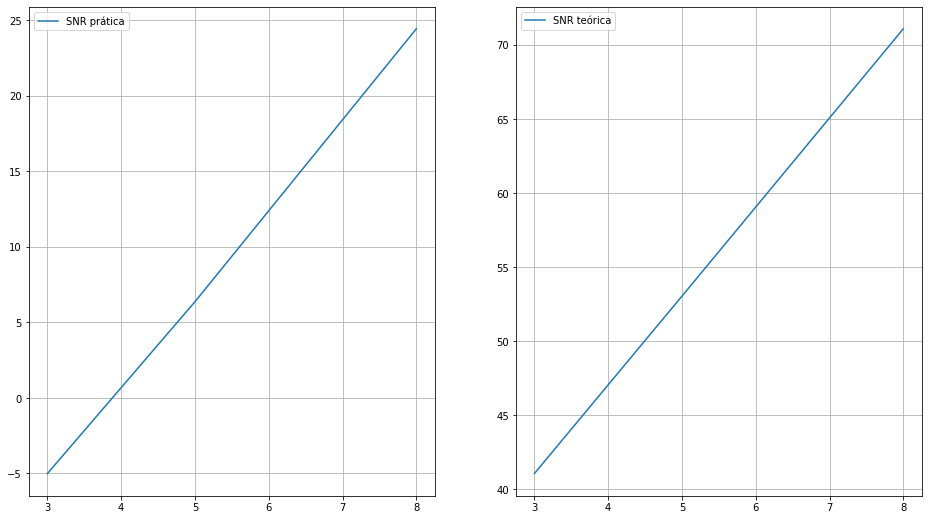

In [17]:
plt.subplots(1,2, figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(R,SNR_PImg, label="SNR prática")
plt.grid("on")
plt.legend()
plt.subplot(1,2,2)
plt.plot(R,SNR_TImg, label="SNR teórica")
plt.grid("on")
plt.legend()

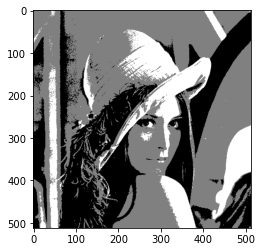

In [18]:
img_3bits = desc_Img[0].reshape((512,512))
plt.imshow(img_3bits,cmap = "gray")

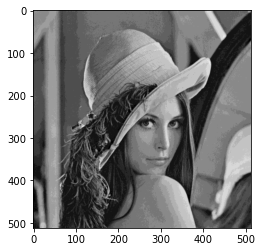

In [19]:
img_5bits = desc_Img[1].reshape(512,512)
plt.imshow(img_5bits,cmap = "gray")

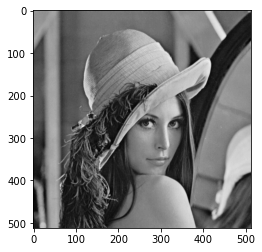

In [20]:
img_8bits = desc_Img[2].reshape(512,512)
plt.imshow(img_8bits,cmap = "gray")

# Deteção e Correção de erros

Construa uma função que implemente o Hamming(8,4). Utilize a seguinte matriz geradora:

In [21]:
G = np.array([[1,0,0,0,1,1,0,1],
              [0,1,0,0,1,0,1,1],
              [0,0,1,0,0,1,1,1],
              [0,0,0,1,1,1,1,0]])

In [22]:
def Hamming_8_4(arr_bits):
    aux = len(arr_bits) % 4
    nZeros = 4-aux if aux != 0 else 0
    arr_bits = np.append(arr_bits,np.zeros(nZeros),0)
    nLines = int(len(arr_bits)/4)
    arr_binary = np.reshape(arr_bits, (nLines,4))
    arr_binary = np.array([np.dot(arr_binary[i],G)%2 for i in range(nLines)])
    return np.array(arr_binary).flatten()

In [23]:
Hamming_8_4([1,0,0,1,1,0,0,0])

array([1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.])

Construa uma função que dado um Numpy array M bits, para cada 8 bits detecte e corriga possíveis erros, sendo o resultado 4 bits de mensagem.


In [24]:
Ht = G.transpose()
print(Ht)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 1 0 1]
 [1 0 1 1]
 [0 1 1 1]
 [1 1 1 0]]


In [25]:
def detetor(arr_binary):
    step = int(len(arr_binary)/8)
    #Deteta
    new_arr   = np.reshape(arr_binary,(step,8))
    sindromes = np.array([np.dot(new_arr[i],Ht) for i in range(step)])
    sindromes = sindromes%2    
    #corrige
    if(len(arr_binary)  == 8):
        new_arr = arr_binary[0:4]
        aux_arr = np.logical_xor(new_arr,sindromes)
        aux_arr = aux_arr.flatten().astype(int)
    else:
        arr_bits = np.reshape(arr_binary,(step,8))
        arr_bits = arr_bits[:,0:4]
        aux_arr  = np.array([np.logical_xor(arr_bits[i], sindromes[i]) for i in range(step)])
        aux_arr  = aux_arr.flatten().astype(int)
    
    return aux_arr

Faça um conjunto de testes para verificar o correto funcionamento das funções.

In [26]:
print('Sinal recebido')
test = Hamming_8_4(np.array([0,0,1,1]))
print(test)
test[1] = 1
test[0] = 1
print('Sinal com um erro')
print(test)
print('Palavra corrigida')
print(detetor(test))

Sinal recebido
[0. 0. 1. 1. 1. 0. 0. 1.]
Sinal com um erro
[1. 1. 1. 1. 1. 0. 0. 1.]
Palavra corrigida
[0 0 1 1]


In [27]:
array2 = np.array([1,0,0,1,1,0,0,1])
print("Mensagem inicial")
print(array2)
test2 = Hamming_8_4(array2)
print("Sinal Recebido")
print(test2)
test2[1] = 1
test2[0] = 0
test2[9] = 1
print("Sinal com dois erros")
print(test2)
print("Mensagem corrigida")
print(detetor(test2))

Mensagem inicial
[1 0 0 1 1 0 0 1]
Sinal Recebido
[1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.]
Sinal com dois erros
[0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.]
Mensagem corrigida
[1 0 0 1 1 0 0 1]


Construa uma função que meça a BER entre o array de bits enviado e o array de bits recebido.

In [28]:
def BER_pratico(arr_bin_tx, arr_bin_rx):
    nErros = len(arr_bin_tx) - np.count_nonzero( arr_bin_tx == arr_bin_rx  )
    BER_pratico = nErros/len(arr_bin_tx)       
    return BER_pratico

Com as duas funções realizadas e admitindo que os restantes blocos do emissor, canal e receptor possam ser simulados pela expressão
$y=1*np.logical\_xor(x,np.random.binomial(1, BER_t,len(x)))$
, onde $BER_t$ contém o valor pretendido para o bit error rate.

Meça o BER antes e após a correcção de erros, para diferentes valores de $BER_t$.

In [29]:
#x - array de bits a entrar no canal
#y - array de bits a sair do canal
# BERt - ainda não está definido.

fs = 48000
ts = 1/fs
t = np.arange(0,0.001,ts)
x = 1000 * t

Vq, Iq = Quantific(4,max(x),'midtread')
x0 = Quantificador(x,Vq,Iq)
cod_x = Codific(x0,4)
hamming = Hamming_8_4(cod_x)

y = 1 * np.logical_xor( hamming, np.random.binomial( 1, 0.23, len(hamming) ) )
print(BER_pratico(hamming,y))
print(BER_pratico(detetor(hamming),detetor(y)))
print()

y = 1 * np.logical_xor( hamming, np.random.binomial( 1, 0.5, len(hamming) ) )
print(BER_pratico(hamming,y))
print(BER_pratico(detetor(hamming),detetor(y)))

0.2421875
0.4375

0.5234375
0.4270833333333333


Considere o sinal de áudio previamente gravado. Meça SNR na recepção, o BER antes e após a correcção de erros, para diferentes valores de  𝐵𝐸𝑅𝑡 . (considera-se que o ruído é a diferença entre o sinal à entrada do transmissor e o sinal à saída do receptor); Comente os resultados obtidos.

In [30]:
file = 'audio.wav'
Fs, x = wav.read(file)

Vq, Iq = Quantific(5,max(x),'midtread')
x0 = Quantificador(x,Vq,Iq)
cod_x = Codific(x0,5)
desc_x = Descodific(cod_x,5)
hamming = Hamming_8_4(cod_x)
detecao = detetor(hamming)

desc_com_correcao = Descodific(detecao,5)

SNRp0 = Measure_SNRp(x,np.array(desc_x).flatten())
SNRp1 = Measure_SNRp(x,desc_com_correcao)

print("Antes da correção\n", SNRp0)
print("Depois da correção\n", SNRp1)
print()
y = 1 * np.logical_xor( hamming, np.random.binomial( 1, 0.23, len(hamming) ) )
print("Antes")
print(BER_pratico(hamming,y))
print("Depois")
print(BER_pratico(detetor(hamming),detetor(y)))
print()
y = 1 * np.logical_xor( hamming, np.random.binomial( 1, 0.5, len(hamming) ) )
print("Antes")
print(BER_pratico(hamming,y))
print("Depois")
print(BER_pratico(detetor(hamming),detetor(y)))

<ipython-input-8-9378aacda499>:3: RuntimeWarning: overflow encountered in int_scalars
  SNRp = 10 * np.log10(sum(signal**2) / sum(error**2))
<ipython-input-8-9378aacda499>:3: RuntimeWarning: invalid value encountered in log10
  SNRp = 10 * np.log10(sum(signal**2) / sum(error**2))


Antes da correção
 nan
Depois da correção
 nan

Antes
0.23068288780120483
Depois
0.4203125

Antes
0.5006577089608434
Depois
0.49946112575301205


- Com a probabiladade de 0.23 consegue corrigir informação;
- Já com uma probabilidade de 0.50 o BER antes e depois da correção é igual logo não consegue corrigir informação

Considere a imagem fornecida e meça a SNR e o BER com e sem correção de erros.
Visualize a imagem no receptor e comente os resultados.

In [32]:
im = Image.open("lena_gray.bmp")
img = np.array(im)
descodificacoes = []
descodificacoesComCorrecao = []
hammingList = []

for row in img:
    Vq, Iq = Quantific(8,Vmax,'midtread')
    x0 = Quantificador(row,Vq,Iq)
    cod = Codific(x0,8)
    descodificacoes.append(Descodific(cod,8))
    hamming = Hamming_8_4(cod)
    hammingList = np.append(hammingList,hamming)
    detecao = detetor(hamming)
    descodificacoesComCorrecao.append(Descodific(detecao,8))   
             
SNRp0 = Measure_SNRp(img.flatten(),np.array(descodificacoes).flatten())
SNRp1 = Measure_SNRp(img.flatten(),np.array(descodificacoesComCorrecao).flatten())

print("Antes da correção\n", SNRp0)
print("Depois da correção\n", SNRp1)

im2 = Image.fromarray(np.array(descodificacoes).astype(np.uint8))
im3 = Image.fromarray(np.array(descodificacoesComCorrecao).astype(np.uint8))

im2.show()
im3.show()

Antes da correção
 22.38021092587973
Depois da correção
 22.38021092587973


In [33]:
y = 1 * np.logical_xor( hammingList, np.random.binomial( 1, 0.23, len(hammingList) ) )
print("Antes")
print(BER_pratico(hammingList,y))
print("Depois")
print(BER_pratico(detetor(hammingList),detetor(y)))
print()
y = 1 * np.logical_xor( hammingList, np.random.binomial( 1, 0.5, len(hammingList) ) )
print("Antes")
print(BER_pratico(hammingList,y))
print("Depois")
print(BER_pratico(detetor(hammingList),detetor(y)))

Antes
0.23003029823303223
Depois
0.42129087448120117

Antes
0.5001909732818604
Depois
0.49996185302734375


- Com a probabiladade de 0.23 consegue corrigir informação;
- Já com uma probabilidade de 0.50 o BER antes e depois da correção é igual logo não consegue corrigir informação